## Import Packages

In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, ToTensor, Normalize

In [2]:
from models.fcn import FCN
from utils.data import VOC2012, CenterCropWithIgnore, CenterCropWithIgnore
from utils.metric import compute_meanIU, compute_confusion

## Set environments

In [3]:
num_classes = 21

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
model = FCN()

In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

In [7]:
dataset = VOC2012('./VOC2012',
                  input_transform=Compose([
                      CenterCrop(512),
                      ToTensor(),
                      Normalize([.485, .456, .406], [.229, .224, .225]),
                  ]), target_transform=CenterCropWithIgnore(512, 255))
loader = DataLoader(dataset, num_workers=1, batch_size=1, shuffle=True)

## Define train/test function

In [8]:
def train(model, loader, optimizer):
    model.to(device)
    model.train()

    all_loss = 0
    all_conf = torch.zeros(num_classes, num_classes)
    for i, data in enumerate(loader):
        image, label = data[0].to(device), data[1].squeeze(0).to(device)

        optimizer.zero_grad()
        pred = model.forward(image)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        val, pred_seg = pred.cpu().max(1)
        all_loss += loss.item()
        all_conf = all_conf + compute_confusion(pred_seg, label.cpu())
        meaniu = compute_meanIU(all_conf)
    
    return all_loss / len(loader), meaniu

In [9]:
def test(model, loader):
    model.to(device)
    model.eval()

    all_loss = 0
    all_conf = torch.zeros(num_classes, num_classes)
    for i, data in enumerate(loader):
        image, label = data[0].to(device), data[1].squeeze(0).to(device)

        pred = model.forward(image)
        loss = criterion(pred, label)

        val, pred_seg = pred.cpu().max(1)
        all_loss += loss.item()
        all_conf = all_conf + compute_confusion(pred_seg, label.cpu())
        meaniu = compute_meanIU(all_conf)

    return all_loss / len(loader), meaniu

## Train and test

In [10]:
epoch = 10

In [11]:
for e in range(epoch):
    loss, iu = train(model, loader, optimizer)
    print(f'Train [{e}/{epoch}] loss: {loss:.4f}, meanIoU: {iu:.4f}')

C:\Users\maybe\conda\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train [0/10] loss: 1.3551, meanIoU: 0.0375
Train [1/10] loss: 1.0052, meanIoU: 0.0000
Train [2/10] loss: 0.7689, meanIoU: 0.0000
Train [3/10] loss: 0.6428, meanIoU: 0.0000
Train [4/10] loss: 0.5588, meanIoU: 0.0000
Train [5/10] loss: 0.4622, meanIoU: 0.0000
Train [6/10] loss: 0.3824, meanIoU: 0.0000
Train [7/10] loss: 0.4451, meanIoU: 0.0000
Train [8/10] loss: 0.3114, meanIoU: 0.0000
Train [9/10] loss: 0.3040, meanIoU: 0.0000


In [12]:
loss, iu = test(model, loader)
print(f'Test [{e}/{epoch}] loss: {loss:.4f}, meanIoU: {iu:.4f}')

Test [9/10] loss: 0.2191, meanIoU: 0.0000


## Visualize

In [13]:
import matplotlib.pyplot as plt

In [14]:
def get_voc_colormap():
    N = 256
    VOCcolormap = np.zeros([N, 3], dtype=np.uint8)
    for i in range(0, N):
        (r,b,g,idx)=(0,0,0,i)
        for j in range(0, 8):
            r = r | ((idx & 1) << (7 - j))
            g = g | ((idx & 2) << (7 - j))
            b = b | ((idx & 4) << (7 - j))
            idx = idx >> 3
        VOCcolormap[i, :] = [r, g >> 1, b >> 2]
    return VOCcolormap

def return_pascal_segmentation(input_im):
    VOCcolormap = get_voc_colormap()
    im = Image.fromarray(input_im, mode='P')
    im.putpalette(np.reshape(VOCcolormap, 768, 'C'))
    return im

def display(pred):
    im_idx = 0
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(data[0][im_idx,:,:,:].permute(1,2,0)) # C x H x W --> H x W x C
    plt.title('input image with mean subtracted')

    plt.subplot(1,3,2)
    plt.imshow(return_pascal_segmentation(data[1][im_idx,0,:,:].numpy().astype(np.uint8)))
    plt.title('ground truth segmentation')

    plt.subplot(1,3,3)
    val, pred_seg = pred.cpu().max(1)
    plt.imshow(return_pascal_segmentation(pred_seg[im_idx].numpy().astype(np.uint8)))
    plt.title('predicted segmentation')

C:\Users\maybe\conda\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


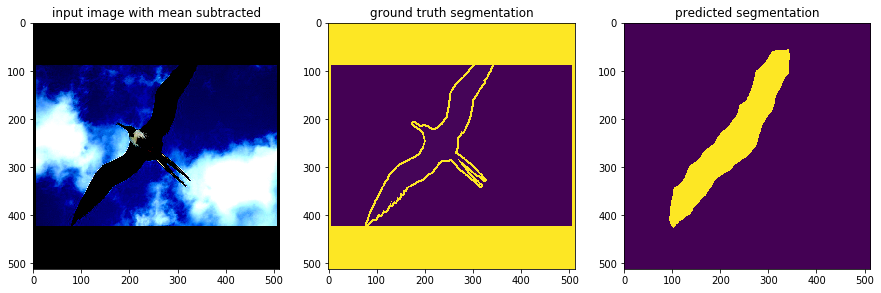

In [15]:
model.to(device)
model.eval()

all_loss = 0
all_conf = torch.zeros(num_classes, num_classes)
for i, data in enumerate(loader):
    image, label = data[0].to(device), data[1].squeeze().to(device)

    pred = model.forward(image)
    
    val, pred_seg = pred.cpu().max(1)

    display(pred)
    break